In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import torch
from scipy.optimize import minimize
import deepwave

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, resample
import cv2

import deepinvhessian.fwi as fwi
from deepinvhessian.utilities import *
import deepinvhessian.fwi_lbfgs as fwi_lbfgs

In [2]:
set_seed(14)
# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare data

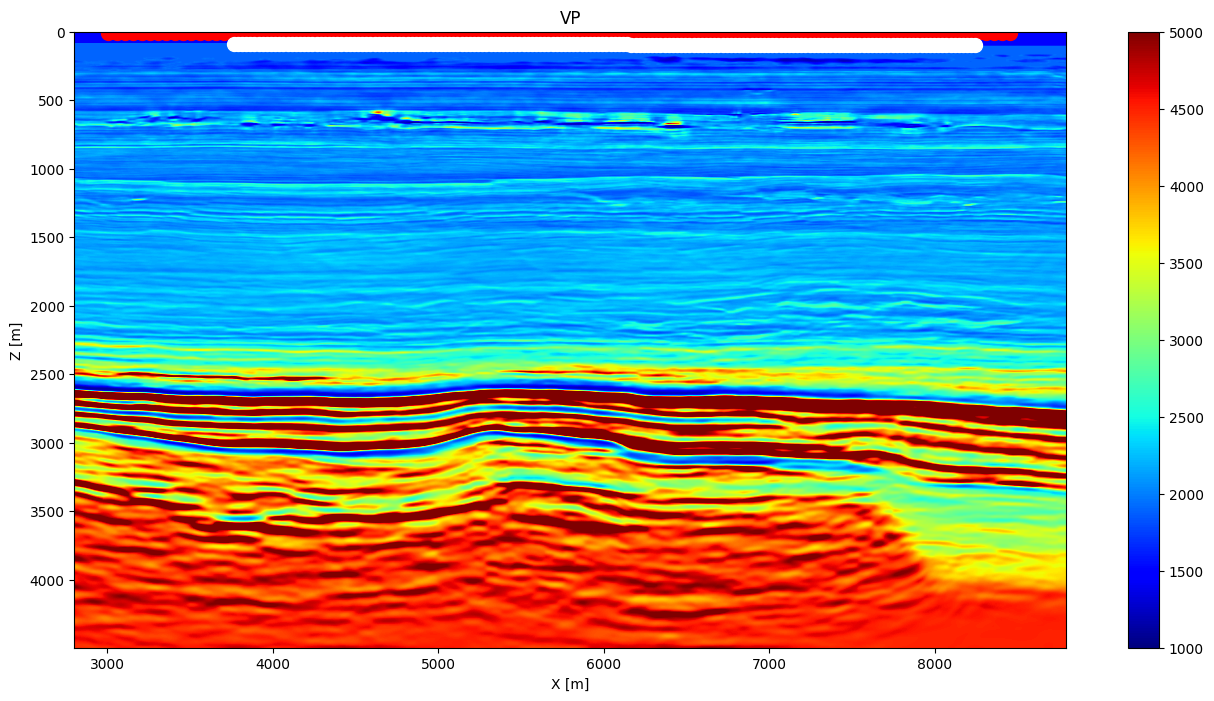

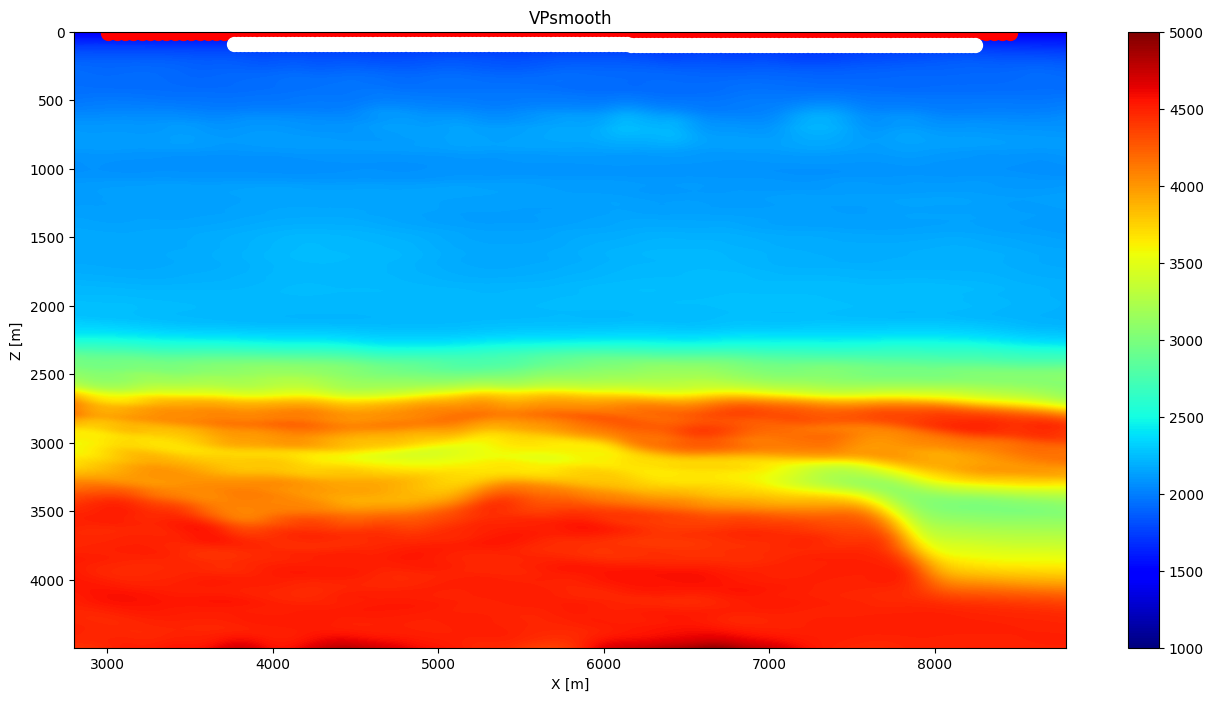

In [3]:
# Load from input file
inputdata = np.load('../data/input_nofs_full_volvesynth.npz')

# Velocity 
vel = inputdata["vel"].T

# Smooth velocity
nsmooth = 41
smooth = np.ones(nsmooth)/nsmooth
velsm = filtfilt(smooth, 1, filtfilt(smooth, 1, vel).T).T
js, jr = 1, 1
nx, nz = vel.shape
x = inputdata["x"]
z = inputdata["z"]
s = inputdata["s"][:, ::js]
r = inputdata["r"][:, ::jr]
ns, nr = s.shape[1], r.shape[1]
nx, nz = x.size, z.size

t = inputdata['t']
dt = t[1]
d = inputdata['p'].transpose(0, 2, 1)[::js, ::jr]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(vel.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
plt.colorbar(im);

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth')
ax.axis('tight')
plt.colorbar(im);

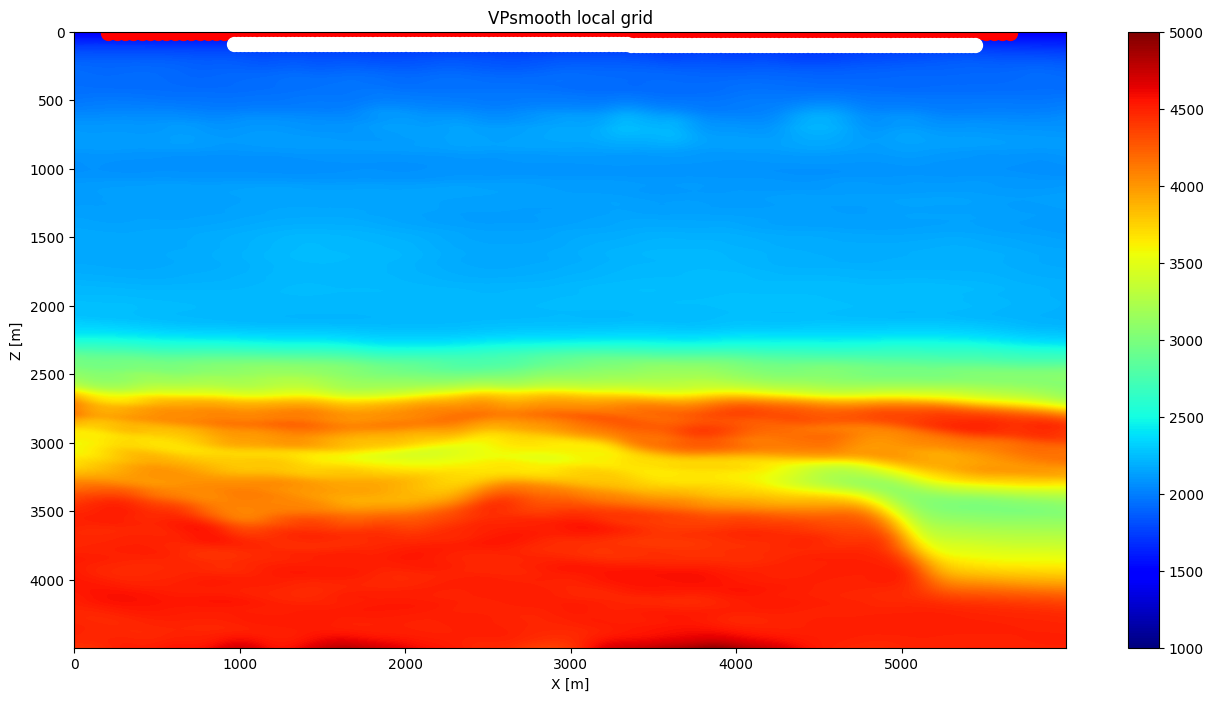

In [4]:
# Convert from global to local grid
xorig = x[0]
x -= xorig
dx, dz = x[1], z[1]

s[0] -= xorig
r[0] -= xorig

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(velsm.T, cmap='jet', vmin=1000, vmax=5000, extent=(x[0], x[-1], z[-1], z[0]))
ax.plot(s[0], s[1], '.r', ms=20)
ax.plot(r[0], r[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VPsmooth local grid')
ax.axis('tight')
plt.colorbar(im)

In [5]:
# Resample data
print(d.shape)
d2 = resample(d, d.shape[-1]*2, axis=-1)
print(d2.shape)

(110, 180, 2351)
(110, 180, 4702)


In [6]:
# Rescale models 
model_init = cv2.resize(velsm.T, (480, 360))
model_init = torch.tensor(model_init).float()
model_true = cv2.resize(vel.T, (480, 360))
model_true = torch.tensor(model_true).float()

In [7]:
par = {
        # model parameters
        'nx':480,   'dx':12.5,  'ox':0,
        'nz':360,   'dz':12.5,  'oz':0,
        'nr':180,   'dr':torch.tensor(r[0]),  'orec':0,  'rz':torch.tensor(r[1]),
        'num_shots':110,   'ds':torch.tensor(s[0]),  'os':0,  'sz':torch.tensor(s[1]),
        'nt':4702,  'dt':0.001,  'ot':0,
        'num_sources_per_shot': 1, 'num_receivers_per_shot': 180,
        'num_dims':2,
        'num_batches':110,
        'freq': 4,
        'exp_name': 'Exp-volve-synthetic',
        'step_size': 1e3,
        'loss_fn': 'l2-norm'
}
# Load the wavelet estimated from the data
wavelet = np.load(f'estimated_wavelets/Volve_synthetic/wav_7Hz.npz')['wav']

In [8]:
# Initialize the FWI class
params = fwi.FWIParams(par,torch.tensor(wavelet[:par['nt']]), 'volve_synthetic')
# Get the source receiver coordinates
x_s1, x_r1 = params.get_coordinate('volve_synthetic')
# Create a wavelet for every source
source_amplitudes = params.create_wavelet(torch.tensor(wavelet))
# Simulated the true data
data_true = fwi.forward_modelling(params, model_true, device).cpu().numpy()
data_true = torch.tensor(data_true).float()
# data = fwi.forward_modelling(params, model_init.detach().clone(), device).cpu().numpy()

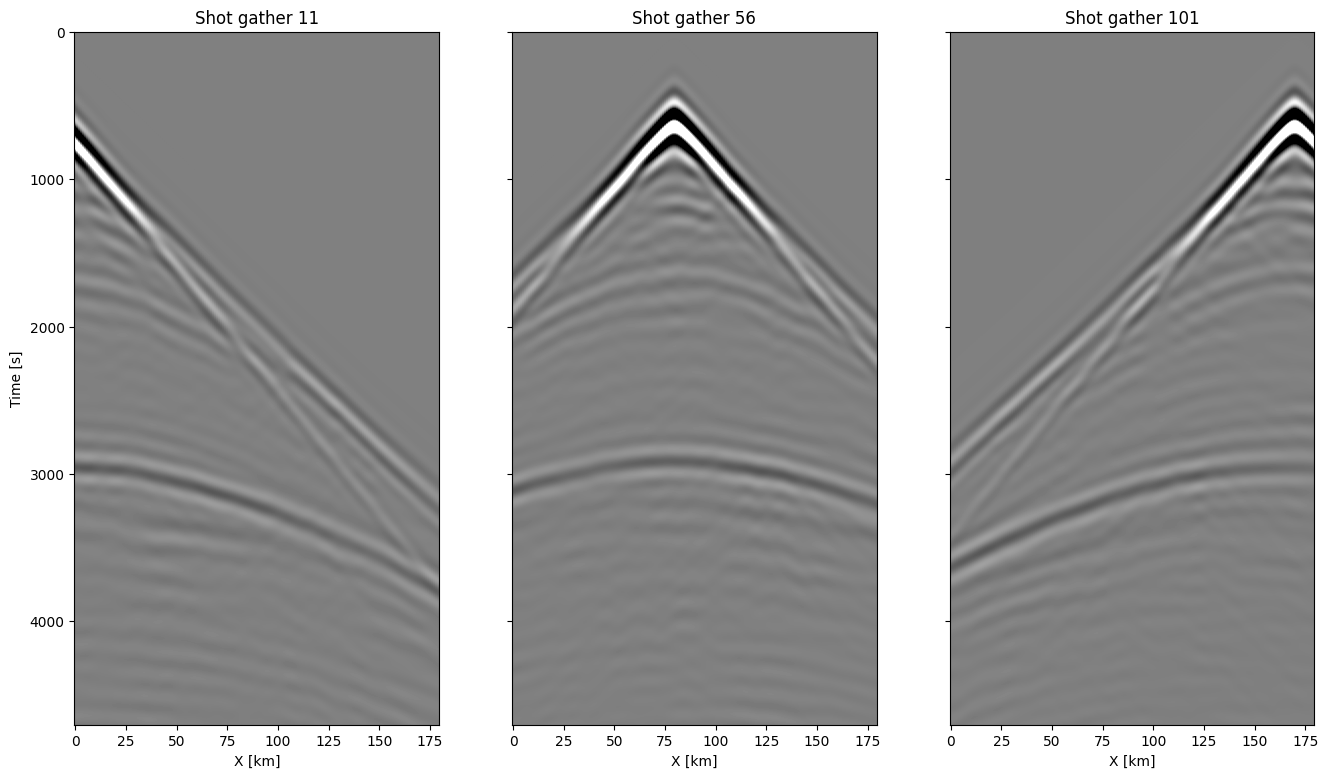

In [9]:
show_3_shots(-1*data_true, [10, 55, 100], clip=0.2)

In [10]:
# show_3_shots(-1*data, [10, 55, 100], clip=0.2)

Text(0.5, 1.0, 'Source wavelet')

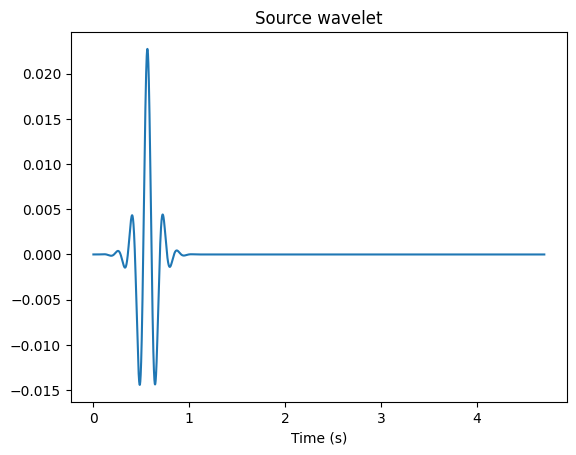

In [11]:
# Visualize the source wavelet
plt.plot(np.arange(0,par['nt'])*par['dt'], source_amplitudes[0,0,:])
plt.xlabel('Time (s)')
plt.title('Source wavelet')

## Run experiment

In [5]:
# Create folder to save the results
exp_name = 'Exp_VolveSynthetic_LBFGS'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [13]:
# Create tensors
model_true = torch.tensor(model_true, dtype=torch.float32)
model_init = torch.tensor(model_init, dtype=torch.float32)
mask = torch.ones_like(model_init, dtype=torch.float32)
mask[:25] = 0

In [14]:
# Initialize the FWI class
fwi = fwi_lbfgs.FWI_LBFGS(data_true, source_amplitudes, params.s_cor, params.r_cor, params.dx, params.dt, 
                          params.num_batches, model_true.shape, mask.to(device), scaling=1., device=device)
# Perform the forward pass
fwi.forward(model_init.detach().cpu().numpy().ravel(), scipy=True)
# Compute the gradient
grad = fwi.grad(model_init.detach().cpu().numpy().ravel(), scipy=True)[-1]
# Compute the gradient scaling
fwi.scaling = (grad * mask.cpu().numpy().ravel()).max()
print(fwi.scaling)

Func
Loss 0.007317940689972602
Grad
1.0
6.362701476803068e-09


In [15]:
# Create functions to run FWI with Scipy optimization
fun = lambda x: fwi.forward(x, scipy=True)
grad = lambda x: fwi.grad(x, scipy=True)[-1]
callback = lambda x: fwi.callback(x, model_true, MSSIM, data_residual, nWE)

In [16]:
MSSIM, data_residual, nWE = [], [], []
model0 = model_init.clone().ravel()
# Run FWI using Scipy L-BFGS
nl = minimize(fun, model0, jac=grad,
              method='L-BFGS-B', 
              callback=callback,
              options=dict(maxiter=50,),
             )
MSSIM = np.array(MSSIM)
nWE = np.array(nWE)
data_residual = np.array(data_residual)

Func
Loss 1150131.075086913
Grad
6.362701476803068e-09
Func
Loss 1150081.6893373805
Grad
6.362701476803068e-09
Func
Loss 1149884.2709843218
Grad
6.362701476803068e-09
Func
Loss 1149093.8634240516
Grad
6.362701476803068e-09
Func
Loss 1145933.1920351938
Grad
6.362701476803068e-09
Func
Loss 1133301.6118982127
Grad
6.362701476803068e-09
Func
Loss 1083491.7334960038
Grad
6.362701476803068e-09
Func
Loss 933803.5077945745
Grad
6.362701476803068e-09
Func
Loss 933803.5077945745
Func
Loss 882918.0687864552
Grad
6.362701476803068e-09
Func
Loss 882918.0687864552
Func
Loss 809490.9168192982
Grad
6.362701476803068e-09
Func
Loss 809490.9168192982
Func
Loss 769734.6948929788
Grad
6.362701476803068e-09
Func
Loss 769734.6948929788
Func
Loss 724028.1573993564
Grad
6.362701476803068e-09
Func
Loss 724028.1573993564
Func
Loss 679457.5553251677
Grad
6.362701476803068e-09
Func
Loss 679457.5553251677
Func
Loss 635218.8819326151
Grad
6.362701476803068e-09
Func
Loss 635218.8819326151
Func
Loss 604779.5629074934


## Plot and save results

In [18]:
# Include the first data residual from the forward pass
first_res = 0.007317940689972602 / params.num_shots
# Descale the data residual
data_res = data_residual * fwi.scaling / params.num_shots
data_res = np.concatenate([np.array([first_res]), data_res], axis=0)

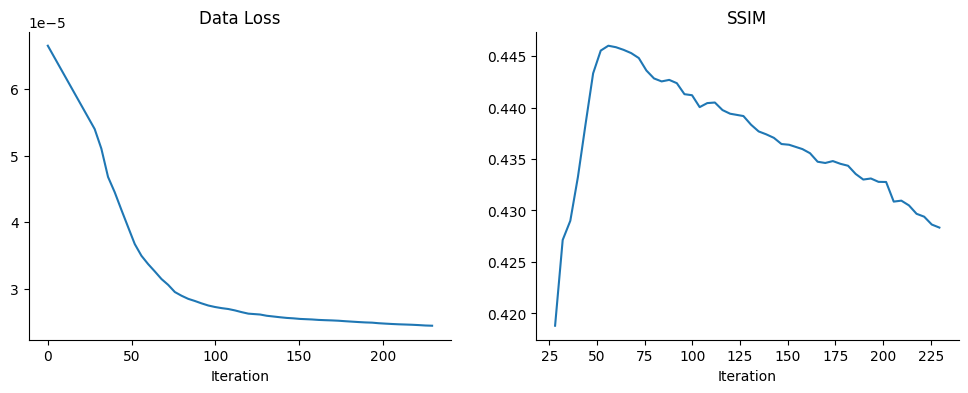

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.concatenate([[0], nWE/params.num_shots]), data_res)
axs[0].set_title('Data Loss')
axs[0].set_xlabel('Iteration')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(nWE/params.num_shots, MSSIM)
axs[1].set_title('SSIM')
axs[1].set_xlabel('Iteration')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

In [20]:
np.savez(f'{exp_name}/results', data_loss=np.array(data_res),
                               mssim=np.array(MSSIM),
                                nWE=np.array(nWE/params.num_shots))

In [21]:
update = nl.x.reshape(360, 480)
np.save(f'{exp_name}/update', update)

Text(0.5, 1.0, 'Inverted Model')

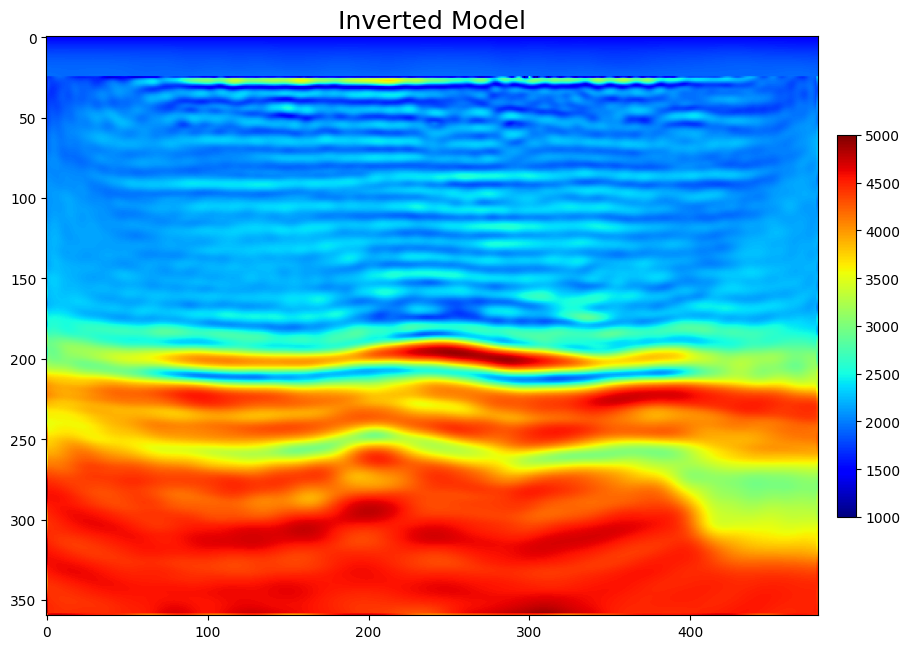

In [22]:
plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(update, vmin=1000, vmax=5000, cmap='jet')
plt.colorbar(shrink=0.62, pad=0.02)
plt.title('Inverted Model', fontsize=18)

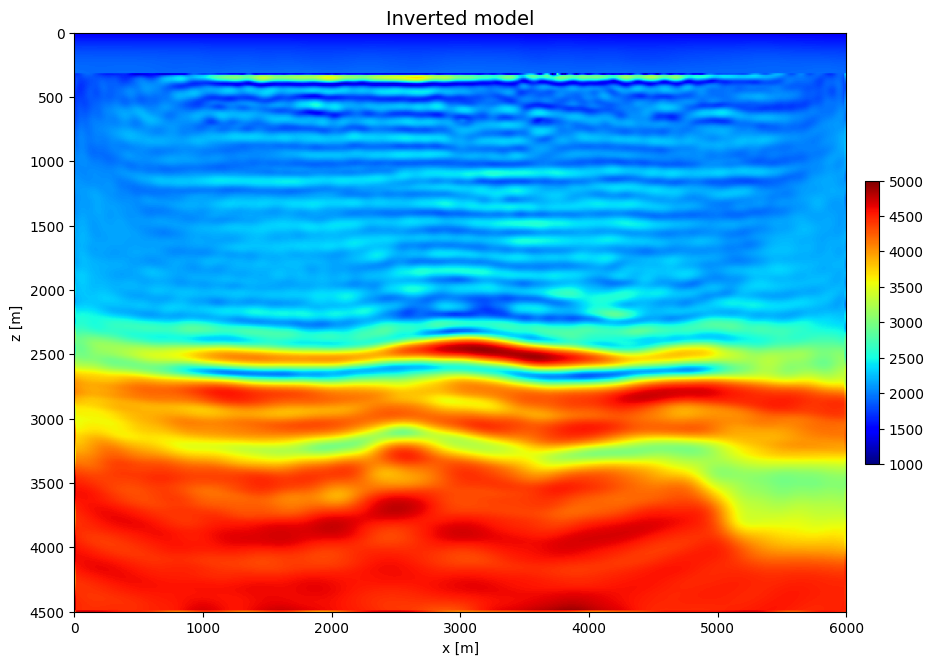

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
im1 = axs.imshow(update, cmap='jet', vmin=1000, vmax=5000, 
                 extent=(0, par['nx']*par['dx'], par['nz']*par['dx'], 0))
axs.set_title(r'Inverted model', fontsize=14)
axs.set_xlabel(r'x [m]')
axs.set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs, shrink=0.46, pad=0.02)
plt.savefig(f'{exp_name}/model_updated', bbox_inches='tight', dpi=300)